In [1]:
import matplotlib.pyplot as plt
import numpy as np
from demo import Demo
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

from lib.utils.helpers import *


In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
ckpt_path = './ckpt/exif_final/exif_final.ckpt'
exif_demo = Demo(ckpt_path=ckpt_path, use_gpu=0, quality=1.0, num_per_dim=10)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Initializing graph on gpu 0
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Restoring parameters from ./ckpt/exif_final/exif_final.ckpt
unknown checkpoint string format ./ckpt/exif_final/exif_final.ckpt setting iteration to 0
Succesfully resuming from ./ckpt/exif_final/exif_final.ckpt
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [4]:
BATCH_SIZE = 1
NUM_WORKERS = 0

In [5]:
ds_choice = "VAS"

In [6]:
if ds_choice == "columbia":
    normal = get_all_files("/media/nas2/Tai/6-tampering-databases/4cam_auth", suffix=".tif")
    spliced = get_all_files("/media/nas2/Tai/6-tampering-databases/4cam_splc", suffix=".tif")
    normal_dl = DataLoader(ColumbiaImageDataset(normal, False, False), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    spliced_dl = DataLoader(ColumbiaImageDataset(spliced, False, False), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
elif ds_choice == "carvalho":
    normal = get_all_files("/media/nas2/Tai/6-tampering-databases/carvalho_pristine", suffix=".png")
    spliced = get_all_files("/media/nas2/Tai/6-tampering-databases/carvalho_tampered", suffix=".png")
    normal_dl = DataLoader(CarvalhoImageDataset(normal, False, False), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    spliced_dl = DataLoader(CarvalhoImageDataset(spliced, False, False), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
elif ds_choice == "korus":
    normal = get_all_files("/media/nas2/Tai/6-tampering-databases/korus_pristine", suffix=".TIF")
    spliced = get_all_files("/media/nas2/Tai/6-tampering-databases/korus_tampered", suffix=".TIF")
    normal_dl = DataLoader(KorusImageDataset(normal, False, False), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    spliced_dl = DataLoader(KorusImageDataset(spliced, False, False), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [7]:
if ds_choice in ("columbia", "carvalho", "korus"):
    normal_avgs = []
    spliced_avgs = []
    for im in tqdm(normal_dl):
        # im, meanshift = exif_demo('./images/demo.png', dense=True)
        meanshift = exif_demo.run(im.squeeze().permute(1,2,0).numpy(), use_ncuts=False, blue_high=True)
        normal_avgs.append(meanshift.mean())

    for im in tqdm(spliced_dl):
        meanshift = exif_demo.run(im.squeeze().permute(1,2,0).numpy(), use_ncuts=False, blue_high=True)
        spliced_avgs.append(meanshift.mean())

    normal_probs = np.array(normal_avgs)
    normal_probs[np.isnan(normal_probs)] = 0
    print(f"normal pred mean: {normal_probs.mean()}")

    spliced_probs = np.array(spliced_avgs)
    spliced_probs[np.isnan(spliced_probs)] = 0
    print(f"spliced pred mean: {spliced_probs.mean()}")

    normal_truths = [0] * len(normal_probs)
    spliced_truths = [1] * len(spliced_probs)

    truths = np.concatenate((normal_truths, spliced_truths), 0)
    probs = np.concatenate((normal_probs, spliced_probs), 0)

In [9]:
if ds_choice in ("VAS"):
    truths = []
    probs = []
    for str_rec in tqdm(tf.python_io.tf_record_iterator("/media/nas2/graph_sim_data/video_advanced_splicing/VAS_test.tfrecord")):
        example = tf.train.Example()
        example.ParseFromString(str_rec)
        frame = np.reshape(np.fromstring(example.features.feature["frame"].bytes_list.value[0], np.uint8)[23:], [1080, 1920, 3])
        # mask = np.reshape(np.fromstring(example.features.feature["mask"].bytes_list.value[0], np.uint8)[18:], [1080, 1920])
        label = example.features.feature["label"].int64_list.value[0]

        truths.append(label)
        meanshift = exif_demo.run(frame, use_ncuts=False, blue_high=True)
        probs.append(meanshift.mean())

0it [00:00, ?it/s]

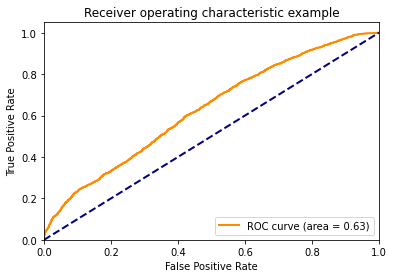

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(truths, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()